In [15]:
import os
import argparse
import time
import torch
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from transformer import Transformer, create_masks
from load_data import ALPHABET_SIZE, EXTRA_CHARS

# Set Paths

In [2]:
data_path = "data/amino_acids.txt"
checkpoint_path = "checkpoints/pretrained.ckpt"
max_length = 256
embedding_size = 512
num_layers = 6

# Load SMILES Strings

In [6]:
smiles_strings = [line.strip("\n") for line in open(data_path, "r")]
print(len(smiles_strings), "strings found")
print("first string:", smiles_strings[0])

20 strings found
first string: C(CC(C(=O)O)N)CN=C(N)N


In [22]:
# We hard-code the 3 letter codes 
# correspodning to the 20 amino acid smiles strings
acids = [
    "Arg",
    "His",
    "Ile",
    "Leu",
    "Lys",
    "Met",
    "Phe",
    "Thr",
    "Trp",
    "Val",
    "Ala",
    "Asn",
    "Asp",
    "Glu",
    "Gly",
    "Ser",
    "Tyr",
    "Cys",
    "Gln",
    "Pro"
]

# Create Transformer w/ Pretrained Weights

In [8]:
model = Transformer(ALPHABET_SIZE, embedding_size, num_layers)

In [9]:
checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
try:
    model.load_state_dict(checkpoint['state_dict'], strict=False)
except AttributeError as e:
    model = nn.DataParallel(model)
    model.load_state_dict(checkpoint['state_dict'], strict=False)

In [10]:
try:
    encoder = model.module.encoder
except AttributeError as e:
    encoder = model.encoder

# Generate Embedding Matrices

In [12]:
def encode_char(c):
    return ord(c) - 32

def encode_smiles(string, start_char=EXTRA_CHARS['seq_start']):
    return torch.tensor([ord(start_char)] + [encode_char(c) for c in string], dtype=torch.long)[:max_length].unsqueeze(0)

In [17]:
embeddings = []
with torch.no_grad():
    for acid, smiles in zip(acids, smiles_strings):
        encoded = encode_smiles(smiles)
        mask = create_masks(encoded)
        embedding = encoder(encoded, mask)[0].numpy()
        embeddings.append(embedding)
        print("embedded {0} {1} into {2} matrix.".format(acid, smiles, str(embedding.shape)))

embedded Arg C(CC(C(=O)O)N)CN=C(N)N into (23, 512) matrix.
embedded His C1=C(NC=N1)CC(C(=O)O)N into (23, 512) matrix.
embedded Ile CCC(C)C(C(=O)O)N into (17, 512) matrix.
embedded Leu CC(C)CC(C(=O)O)N into (17, 512) matrix.
embedded Lys C(CCN)CC(C(=O)O)N into (18, 512) matrix.
embedded Met CSCCC(C(=O)O)N into (15, 512) matrix.
embedded Phe C1=CC=C(C=C1)CC(C(=O)O)N into (25, 512) matrix.
embedded Thr CC(C(C(=O)O)N)O into (16, 512) matrix.
embedded Trp C1=CC=C2C(=C1)C(=CN2)CC(C(=O)O)N into (33, 512) matrix.
embedded Val CC(C)C(C(=O)O)N into (16, 512) matrix.
embedded Ala CC(C(=O)O)N into (12, 512) matrix.
embedded Asn C(C(C(=O)O)N)C(=O)N into (20, 512) matrix.
embedded Asp C(C(C(=O)O)N)C(=O)O into (20, 512) matrix.
embedded Glu C(CC(=O)O)C(C(=O)O)N into (21, 512) matrix.
embedded Gly C(C(=O)O)N into (11, 512) matrix.
embedded Ser C(C(C(=O)O)N)O into (15, 512) matrix.
embedded Tyr C1=CC(=CC=C1CC(C(=O)O)N)O into (26, 512) matrix.
embedded Cys C(C(C(=O)O)N)S into (15, 512) matrix.
embedded 

# Compute Amino Acid Vectors

We average the embedding vectors of the characters in each SMILES string to obtain a single, 512-size vector for each amino acid.

In [14]:
vectors = np.stack([emb.mean(axis=0) for emb in embeddings])
vectors.shape

(20, 512)

We find and project to the first two prinicpal components of the 20 amino acids in the 512-dimension vector space.

In [25]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)
reduced.shape

(20, 2)

# Plot Amino Acids in Embedding Space

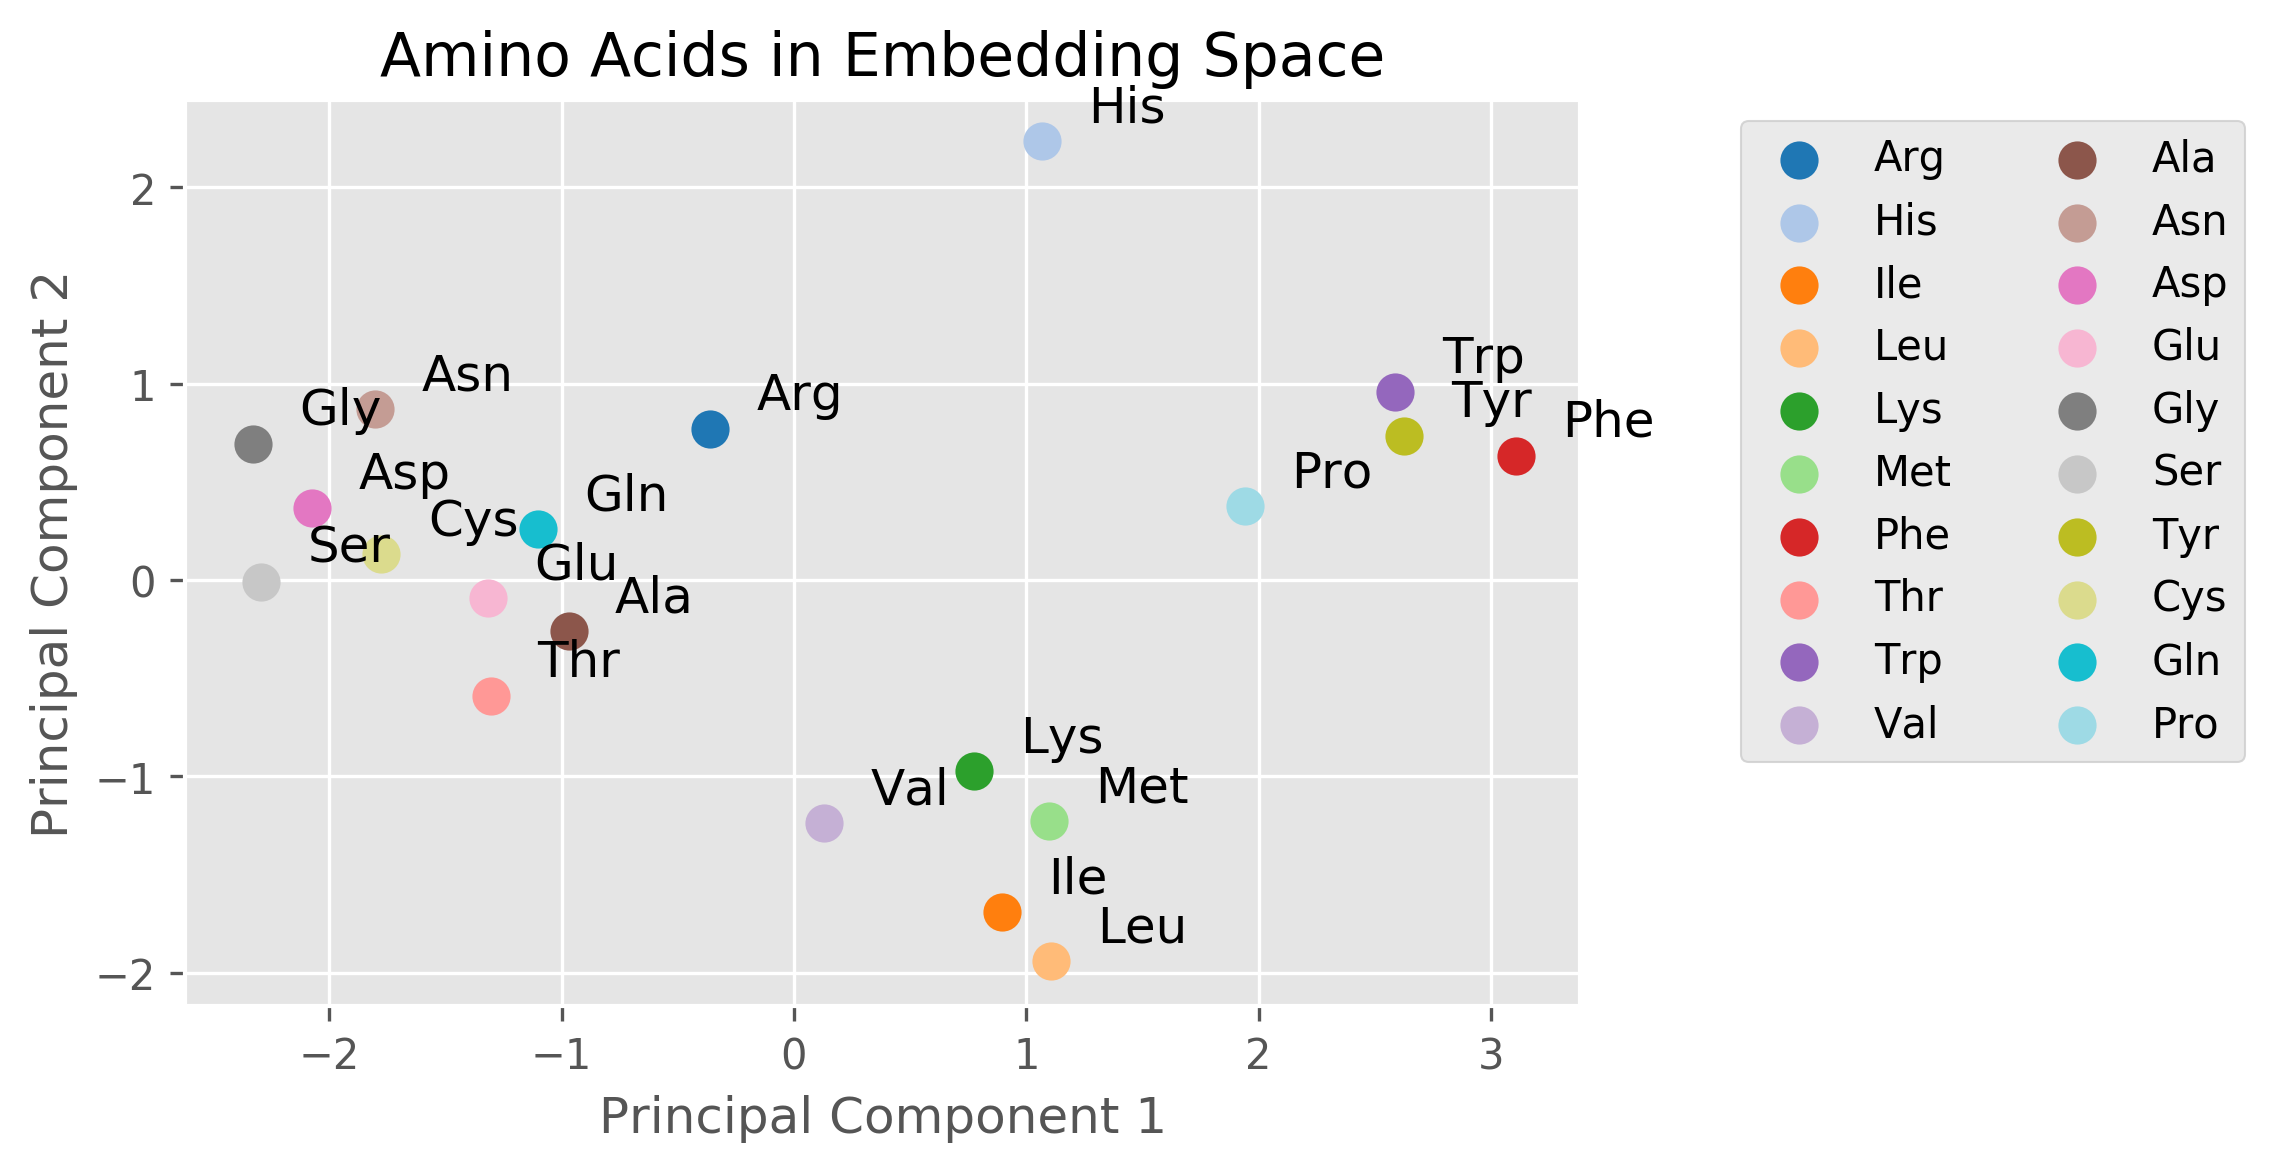

In [27]:
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.dpi'] = 300

cmap = matplotlib.cm.get_cmap('tab20')
for i, acid_name in enumerate(acids):
    x, y = reduced[i, 0], reduced[i, 1]
    plt.scatter(x, y, c=[cmap(i/len(acids))], s=75, label=acids[i])
    plt.text(x+.2, y+.1, acid_name, fontsize=12)
plt.legend(loc="upper left", bbox_to_anchor=(1.1,1), ncol=2)
#plt.gca().set_aspect('equal', adjustable='box')
#plt.tight_layout()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Amino Acids in Embedding Space")
plt.show()